# GBM, Log-Normal PDF, Black-Scholes, IV-Inversion  

$$
\\
$$

**Application of Choice:**
$$
\\
$$

Stock return 
$$
\frac{dS_t}{S_t} = (r + RP) dt + \sigma dW_t
$$

is log-normally distributed with r being the risk-free rate, RP being the equity risk premium and $dW_t$ being a Brownian Motion increment (N(0,dt)), i.e.
$$
\\
$$


## Quick Overview of an SDE (Stochastic Differential Equation) 
$$
\\
$$

**Motivation:** https://www.youtube.com/watch?v=aNP-FZqSAm4&list=PLyQSjcv8LwAEdNgdVnNH02-JTJfrwCt81&index=1
$$
\\
$$

**What is a SDE..., 'da stell ma uns mal jans dumm... :-)** https://www.youtube.com/watch?v=gg7N4QAOcXE&list=PLyQSjcv8LwAEdNgdVnNH02-JTJfrwCt81&index=4
$$
\\
$$

**For the interested student:** https://www.youtube.com/playlist?list=PLyQSjcv8LwAEdNgdVnNH02-JTJfrwCt81

**Implication for Return Density**
    
\begin{equation*}
S_T|\mathcal{F}_0 \; \sim \; S_0 \times e^{(r + RP -0.5 \sigma^2) \times T + \sigma \sqrt{T} \times N(0,1)}
\end{equation*}
$$
\\
$$


**Implication for Price of Call Option on Stock Price**

\begin{align*}
C_0 & := E_0 \left[ \; max(S_T-K,0) \times \; DF_{T}  \right ] \qquad \text{with} \qquad DF_{T} = \text{Stochastic Discount Factor} \qquad \text{and} \qquad K >0 \\\\
&= S_0 \times \Phi(d_1) - K \times \Phi(d_2) \times e^{-r \times T}
\end{align*}

with
$$
d_1 = \frac{\ln S_0/K + (r + \sigma^2/2)\times T}{\sigma \sqrt{T}} \qquad \text{and} \qquad d_2 = d_1 - \sigma \sqrt{T}
$$

and $\Phi(.)$ being the CDF of a Gaussian Density
$$
\\
$$


**Implication for Price of Put Option on Stock Price**

\begin{align*}
P_0 &:= E_0 \left[ \; max(K-S_T,0) \times \; DF_{T}  \right ] \qquad \text{with} \qquad DF_{T} = \text{Stochastic Discount Factor} \qquad \text{and} \qquad K >0 \\\\
&= K \times e^{-r\times T} \times \Phi(-d_2) - S_0 \times \Phi(-d_1)
\end{align*}


**Parametrization:**

In [1]:
#packages
import numpy as np
from scipy.stats import lognorm, norm
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd

import time

In [2]:
#annualized parameters  for S_T|F_0
r      =  0.04  #risk-free rate
RP     =  0.06  #stock's expected risk premium
sigma  = 0.60
S_0    = 1.0

#parameter for forecast length
T     = 1/(12) #1month option.    ...  #1 #1year

#frequency of analysis: daily
dt    = 1/365   

#seed for simulation
seed_  = 789
np.random.seed(seed_)

#NrOfPaths
Omega = 2#5


# 1. Analytical Probability Density Function of Stock Prices

## 1.a Conditional First two Moments

$$
\\
$$

\begin{equation*}
E \frac{S_T}{S_0}|\mathcal{F}_0  =   e^{(r + RP) \times T}  \qquad \text{and} \qquad E \;ln \frac{S_T}{S_0}|\mathcal{F}_0  = (r + RP - 0.5 \sigma^2) \times T
\end{equation*}

$$
\\
$$

\begin{equation*}
Var \frac{S_T}{S_0} |\mathcal{F}_0 = e^{2 \times (r+RP)\times T } \; \times (e^{\sigma^2 \times T} - 1)\qquad \text{and} \qquad Var \; ln \frac{S_T}{S_0} |\mathcal{F}_0 = \sigma^2 \times T
\end{equation*}


 


## 1.b Probability Density Function and Cumulative Density Function

In [3]:
#rv_T := ln S_T / S_O - logNormalDistributino
mean_ln = (r + RP - 0.5*sigma**2)*T
std_ln  = sigma*np.sqrt(T)
dist_ln = lognorm([std_ln], loc=mean_ln)


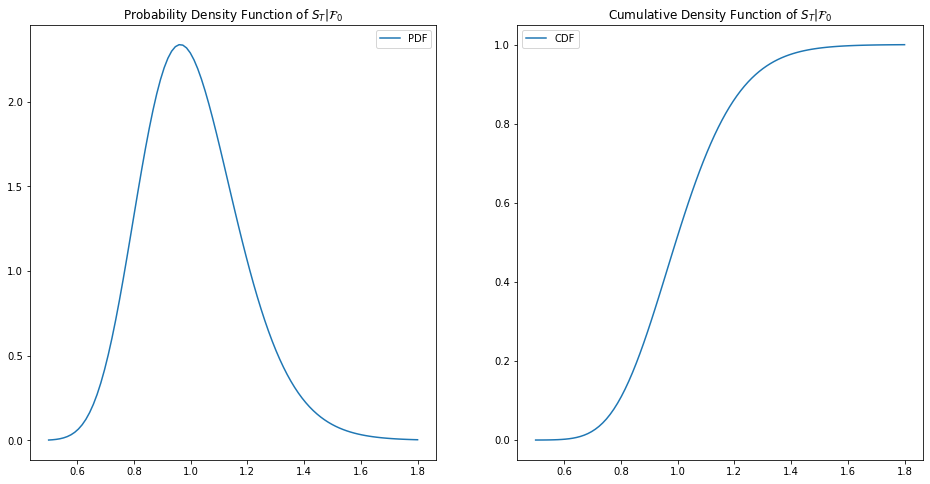

In [4]:
#Visualization of PDF and CDF (S_T|F_0)
ST_F0 = np.linspace(0.5,1.8*S_0, num=100)

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(ST_F0, dist_ln.pdf(ST_F0), label = 'PDF')   
ax[0].legend()
ax[0].set_title("Probability Density Function of $S_T|\mathcal{F}_0$")
#
ax[1].plot(ST_F0, dist_ln.cdf(ST_F0), label = 'CDF') 
ax[1].legend()
ax[1].set_title('Cumulative Density Function of $S_T|\mathcal{F}_0$')
plt.show()

# 2. Simulate Stock Paths


In [5]:
#Simulate S_T in dt steps for one path

def simulate_StockPrice(mean_d_lnS, std_d_lnS, T,dt, S_0):
    mu    = mean_d_lnS
    sigma = std_d_lnS

    S = np.zeros((int(T/dt)+1,1)) + S_0  # 1 + T-yrs (in days), start in S_0
    for t in range(1, int(T/dt+1)):
        BM_lnS    =  np.random.normal(loc = 0, scale = 1, size = 1)
        S[t,0]    =  S[t-1,0] * np.exp( (mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*BM_lnS) 
   
    return S

In [6]:
#show results for two paths
S_Path1 = simulate_StockPrice(r+RP, sigma, T, dt, S_0)
S_Path2 = simulate_StockPrice(r+RP, sigma, T, dt, S_0)

## 2.a: Visualize Two Paths for the Stock Price and Return

Text(0.5, 1.0, 'Which Return Model to Own?')

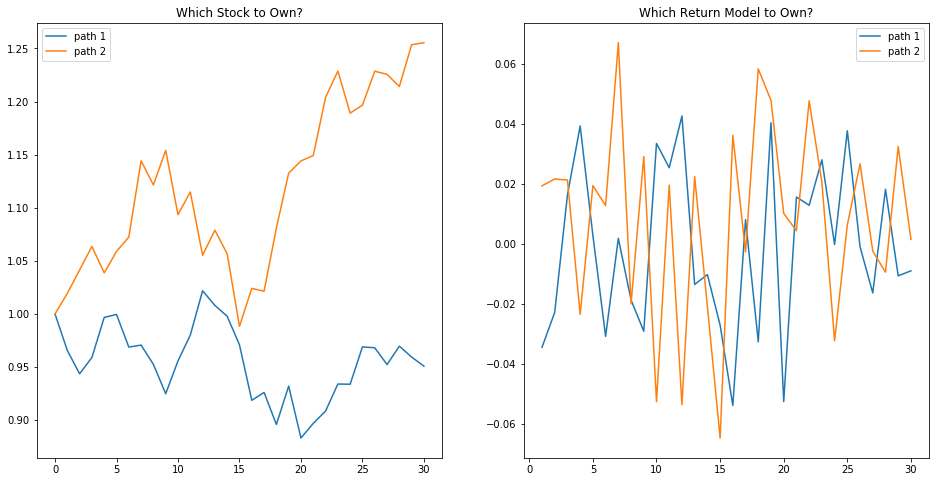

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(range(int(T/dt)+1), S_Path1, label = 'path 1')   
ax[0].plot(range(int(T/dt)+1), S_Path2, label = 'path 2')
ax[0].legend()
ax[0].set_title("Which Stock to Own?")
#
ax[1].plot(range(1,int(T/dt+1)), S_Path1[1:]/S_Path1[:-1]-1, label = 'path 1')   
ax[1].plot(range(1,int(T/dt+1)), S_Path2[1:]/S_Path2[:-1]-1, label = 'path 2')
ax[1].legend()
ax[1].set_title("Which Return Model to Own?")

# 3. Simulate Price of Calls and Puts (i.e. Black-Scholes Model)

Assuming assumptions of Black-Scholes model hold, prices of puts and calls with strike $K$ and maturity $T$ are deterministic functions of the current stock price $S_0$:

$$
\\
$$

\begin{equation*}
C(S_0,.)= S_0 \times \Phi(d_1) - K \times \Phi(d_2) \times e^{-r \times T} \\\\
P(S_0,.)=K \times e^{-r\times T} \times \Phi(-d_2) - S_0 \times \Phi(-d_1)
\end{equation*}

with
$$
d_1 = \frac{\ln S_0/K + (r + \sigma^2/2)\times T}{\sigma \sqrt{T}} \qquad \text{and} \qquad d_2 = d_1 - \sigma \sqrt{T}
$$


 


## 3.a Black-Scholes Option Pricing Implementation

In [8]:
# Black Scholes Option Pricing formula (Closed-form solution)
def black_scholes(S_current, Strike, T_remaining, r, sigma, type='C'):
    S = S_current
    K = Strike
    T = T_remaining
    
    d1 = (np.log(S / K ) + (r + 0.5 * sigma ** 2) * T ) / (sigma * np.sqrt(T ))
    d2 = d1 - sigma*np.sqrt(T)

    if type == 'C':
        C_current = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return C_current
    else:
        P_current = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return P_current
    

## 3.b Simulate Call and Put Prices as a function of the Stock Price

In [9]:
#Simulate C_t and P_t as t moves in dt time steps from 0 to T, (along one path)

def simulate_OptionPrice(S_t, K, Tmt, r, sigma, type='C'):
    #input: S_t: vector of S_t from t = 0 to T
    #input: Tmt: vector of remaining maturity, i.e. T - t
    #NOTE: Tmt needs to be in annual units.
    
    if type == 'C':
        C_t_T = np.zeros((len(S_t),1))    
        for t in range(len(S_t)):
            C_t_T[t] = black_scholes(S_t[t], K, Tmt[t],r,sigma,type='C')
        return C_t_T
    
    else:
        P_t_T = np.zeros((len(S_t),1))    
        for t in range(len(S_t)):
            P_t_T[t] = black_scholes(S_t[t], K, Tmt[t],r,sigma,type='P')
        return P_t_T
            
 

## 3.c Generate Two Paths of a Put and Call with Strike K  

**Decide upon the Strike K**

In [10]:
K = S_0

**Price and Return on Call and Put for Path #1**

In [11]:
#Path 1
S_t = S_Path1
Tmt = (int(T/dt) -  np.linspace(0,  T/dt,  int(T/dt +1) )  ) * dt

## price path of the same call (put) option until maturity
C_path1 = simulate_OptionPrice(S_t, K, Tmt, r, sigma, type='C')
P_path1 = simulate_OptionPrice(S_t, K, Tmt, r, sigma, type='P')

##resulting daily return
r_C_path1 = (C_path1[1:,0] / C_path1[:-1,0])-1
r_P_path1 = (P_path1[1:,0] / P_path1[:-1,0])-1



/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


**Price and Return on Call and Put for Path #2**

In [12]:
#Path 2
S_t = S_Path2
Tmt = (int(T/dt) -  np.linspace(0,  T/dt,  int(T/dt +1) )  ) * dt

## price path of the same call (put) option until maturity
C_path2 = simulate_OptionPrice(S_t, K, Tmt, r, sigma, type='C')
P_path2 = simulate_OptionPrice(S_t, K, Tmt, r, sigma, type='P')

##resulting daily return
r_C_path2 = (C_path2[1:,0] / C_path2[:-1,0])-1
r_P_path2 = (P_path2[1:,0] / P_path2[:-1,0])-1

/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


## 3.d Plot Prices  Stock, Call and Put

**Path #1**

Text(0.5, 1.0, 'Path #1')

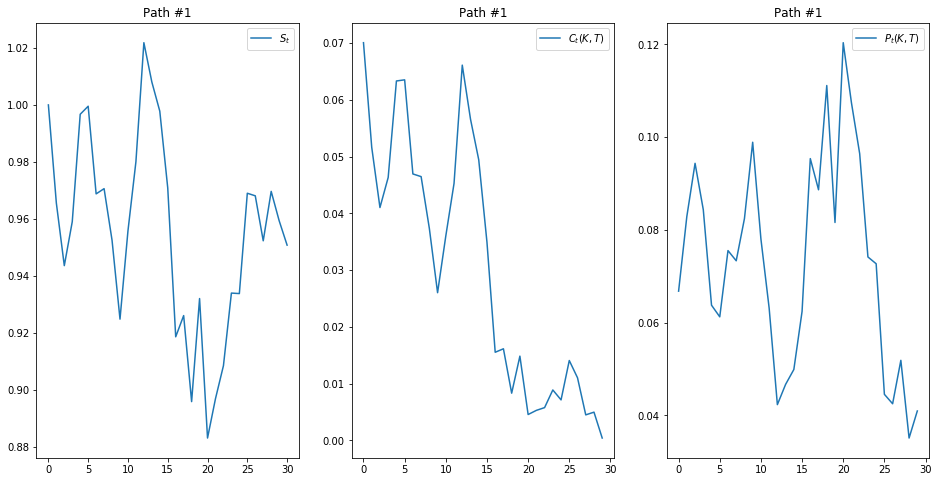

In [13]:
#Visualization: Path #1
 
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].plot(range(0,int(T/dt+1)), S_Path1, label = '$S_t$')   
ax[0].legend()
ax[0].set_title("Path #1")
#
ax[1].plot(range(0, int(T/dt+1)), C_path1 , label = '$C_t(K,T)$')  
ax[1].legend()
ax[1].set_title("Path #1")
#
ax[2].plot(range(0, int(T/dt+1)), P_path1 , label = '$P_t(K,T)$')
ax[2].legend()
ax[2].set_title("Path #1")

 

**Path #2**

Text(0.5, 1.0, 'Path #2')

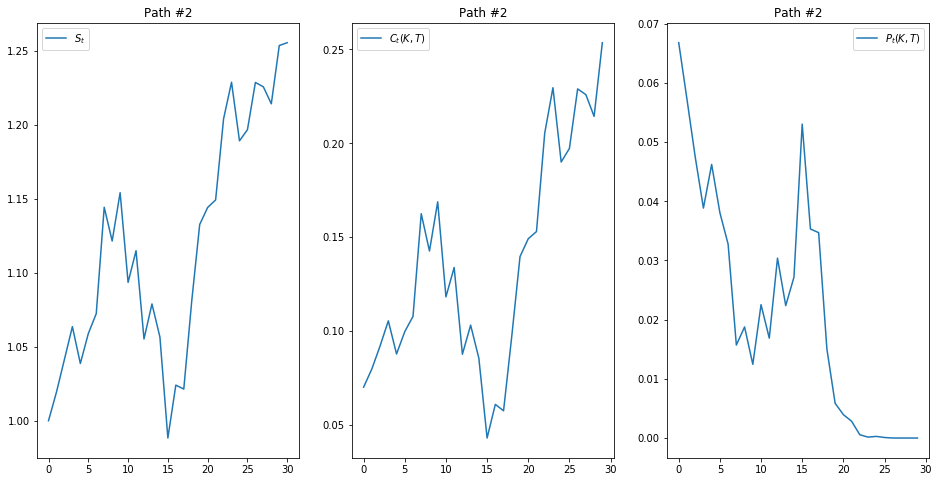

In [14]:
#Visualization: Path #2
 
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].plot(range(0,int(T/dt+1)), S_Path2, label = '$S_t$')   
ax[0].legend()
ax[0].set_title("Path #2")
#
ax[1].plot(range(0, int(T/dt+1)), C_path2 , label = '$C_t(K,T)$')  
ax[1].legend()
ax[1].set_title("Path #2")
#
ax[2].plot(range(0, int(T/dt+1)), P_path2 , label = '$P_t(K,T)$')
ax[2].legend()
ax[2].set_title("Path #2")

## 3.e Plot Return of Stock, Call and Put

**Path #1 and Path #2**

Text(0.5, 1.0, ' Path #2 ')

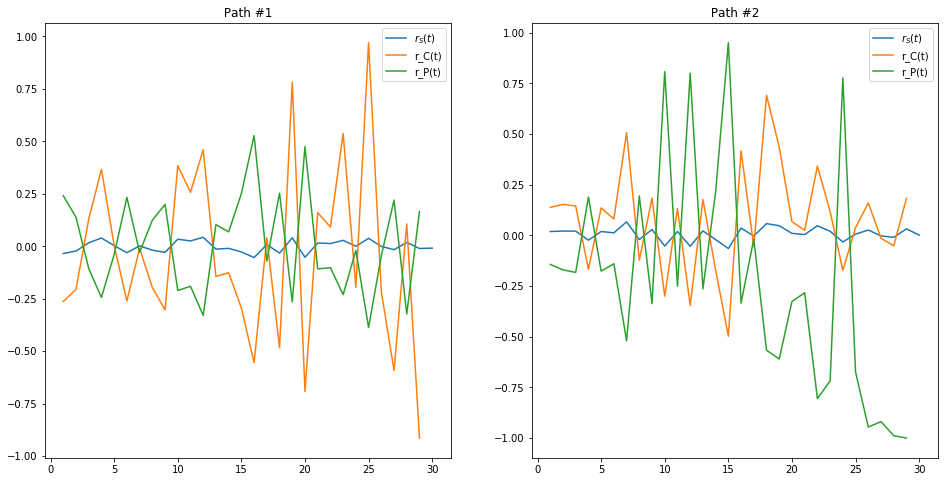

In [15]:

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(range(1,int(T/dt+1)), (S_Path1[1:]/S_Path1[:-1]-1), label = '$r_S(t)$')   
ax[0].plot(range(1, int(T/dt+1)), r_C_path1 , label = 'r_C(t)' )  
ax[0].plot(range(1, int(T/dt+1)), r_P_path1 , label = 'r_P(t)' )
ax[0].legend()
ax[0].set_title(" Path #1 ")
#
ax[1].plot(range(1,int(T/dt+1)), (S_Path2[1:]/S_Path2[:-1]-1) , label = '$r_S(t)$')   
ax[1].plot(range(1, int(T/dt+1)), r_C_path2 , label = 'r_C(t)' )  
ax[1].plot(range(1, int(T/dt+1)), r_P_path2 , label = 'r_P(t)' )
ax[1].legend()
ax[1].set_title(" Path #2 ")
 

# 4. Probability Density Function of Call and Put 

## 4.a Histogram of Returns along Path #1 

/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


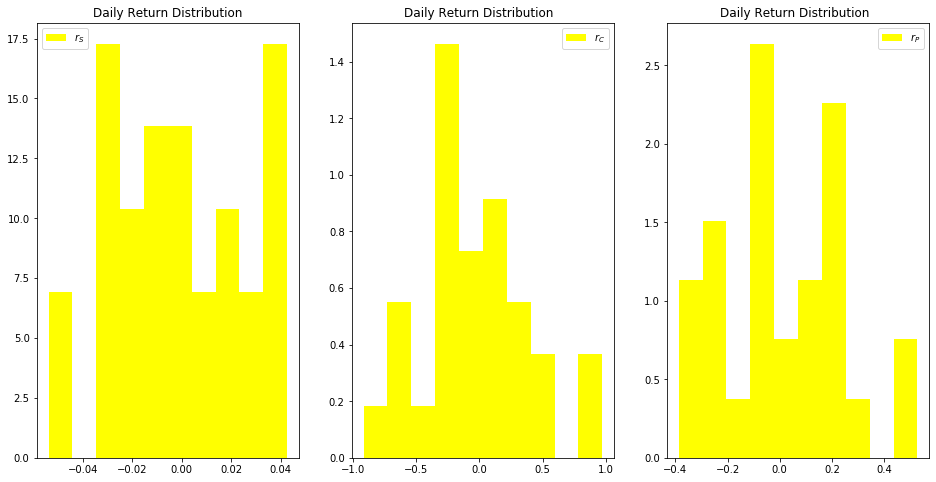

In [16]:
#Realized Time-Series of Daily Option Returns
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].hist(S_Path1[1:]/S_Path1[:-1]-1, bins = 10, color = 'yellow', density=True, label = '$r_S$')
 
ax[0].legend()
ax[0].set_title("Daily Return Distribution")

ax[1].hist(r_C_path1, bins = 10, color = 'yellow', density=True, label = '$r_C$')
 
ax[1].legend()
ax[1].set_title("Daily Return Distribution  ")
#
ax[2].hist(r_P_path1, bins = 10, color = 'yellow', density=True, label = '$r_P$')
 
ax[2].legend()
ax[2].set_title("Daily Return Distribution  ")
#


plt.show()

## 4.b Histogram of Returns along Path #2

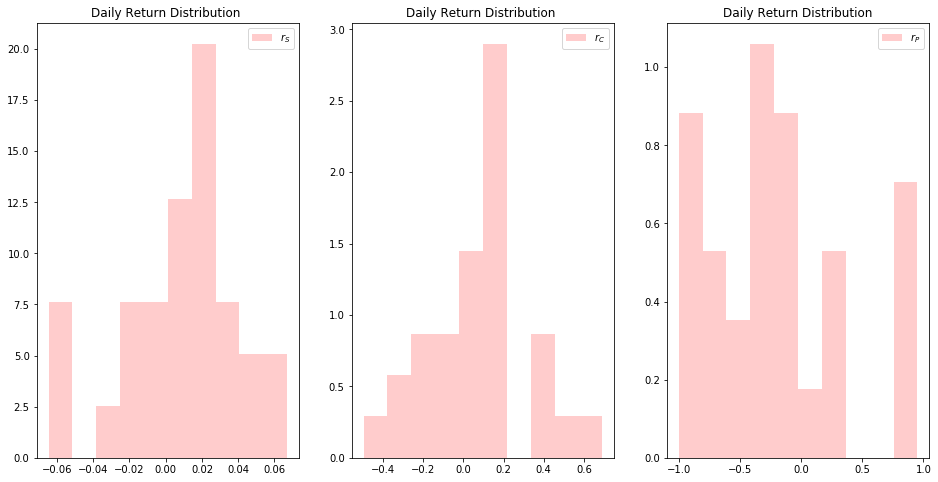

In [17]:
#Realized Time-Series of Daily Option Returns
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].hist(S_Path2[1:]/S_Path2[:-1]-1, bins = 10, color = 'red', alpha=0.2, density=True, label = '$r_S$')
ax[0].legend()
ax[0].set_title("Daily Return Distribution ")

ax[1].hist(r_C_path2, bins = 10, color = 'red', alpha=0.2,density=True, label = '$r_C$')
ax[1].legend()
ax[1].set_title("Daily Return Distribution ")
#
 
ax[2].hist(r_P_path2, bins = 10, color = 'red',alpha=0.2, density=True, label = '$r_P$')
ax[2].legend()
ax[2].set_title("Daily Return Distribution")

plt.show()
 



# 5. More Complex Application: Time-Varying Vol as Step-Up Function

**Goal:** A first encounter with time-varying volatility

**Assume:** Volatility of stock return follows a step function. Whatever todays volatility, it will (is expected to) stay constant at that value till maturity.

$$
\\
$$

**Why?:** Option returns and density will be driven by a second risk factor, i.e. volatility shocks

## 5.a Didactical Visualization Using a Univariate Stochastic Volatility 

$$
\\
$$

$$
\sigma_t = \sigma \times e^{0.2 \times \epsilon_t}, \qquad \epsilon_t \sim N(0,1)
$$

## 5.b Black-Scholes Model with Piece-Wise Constant, yet Stochastic, Volatility 

**Simulate Black-Scholes with piece-wise constant vol process**

In [18]:
#Simulate C_t and P_t as t moves in dt time steps from 0 to T, (along one path) with a MADE-UP Vol Process

def simulate_OptionPrice_SV_Didactical(S_t, K, Tmt, r, sigma, type='C'):
    #input: S_t: vector of S_t from t = 0 to T
    #input: sigma_t: vector random realizations of BS-implied sigma_t
    #input: Tmt: vector of remaining maturity, i.e. T - t
    #NOTE: Tmt needs to be in annual units.
    
    #Didactical purpose: generate sigma_t
    sigma_t = S_t.copy()
    for t in range(0, len(sigma_t)):
        sigma_t[t] = sigma *np.exp(0.2 * np.random.normal(loc = 0, scale = 1, size = 1))
        
    
    if type == 'C':
        C_t_T = np.zeros((len(S_t),1))    
        for t in range(len(S_t)):
            C_t_T[t] = black_scholes(S_t[t], K, Tmt[t],r,sigma_t[t],type='C')
        return C_t_T, sigma_t
    
    else:
        P_t_T = np.zeros((len(S_t),1))    
        for t in range(len(S_t)):
            P_t_T[t] = black_scholes(S_t[t], K, Tmt[t],r,sigma_t[t],type='P')
        return P_t_T, sigma_t

## 5.c:  Path #1 of Prices and Returns for a fixed $K$ and $T$

In [19]:
#Path 1
S_t = S_Path1
Tmt = (int(T/dt) -  np.linspace(0,  T/dt,  int(T/dt +1) )  ) * dt

## price path of the same call (put) option until maturity
C_SV_path1, sigma_path1 = simulate_OptionPrice_SV_Didactical(S_t, K, Tmt, r, sigma, type='C')
P_SV_path1, sigma_path2 = simulate_OptionPrice_SV_Didactical(S_t, K, Tmt, r, sigma, type='P')

##resulting daily return
r_C_SV_path1 = (C_SV_path1[1:,0] / C_SV_path1[:-1,0])-1
r_P_SV_path1 = (P_SV_path1[1:,0] / P_SV_path1[:-1,0])-1

/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


**Visualization of Prices**

Text(0.5, 1.0, 'Path #1')

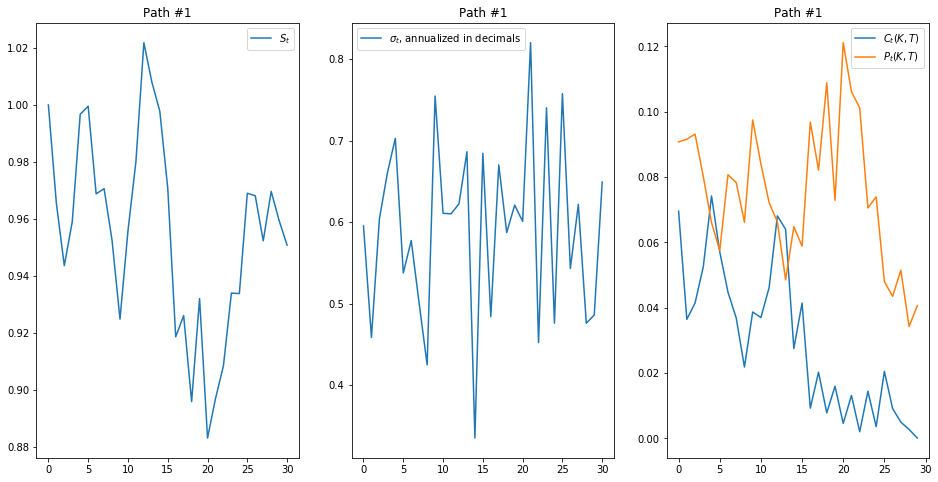

In [20]:
#path 1: Prices
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].plot(range(0,int(T/dt+1)), S_Path1, label = '$S_t$')   
ax[0].legend()
ax[0].set_title("Path #1")
ax[1].plot(range(0,int(T/dt+1)), sigma_path1, label = '$\sigma_t$, annualized in decimals')   
ax[1].legend()
ax[1].set_title("Path #1")
ax[2].plot(range(0, int(T/dt+1)), C_SV_path1 , label = '$C_t(K,T)$')  
ax[2].plot(range(0, int(T/dt+1)), P_SV_path1 , label = '$P_t(K,T)$')
ax[2].legend()
ax[2].set_title("Path #1")

**Visualization of Returns**

Text(0.5, 1.0, 'Path #1')

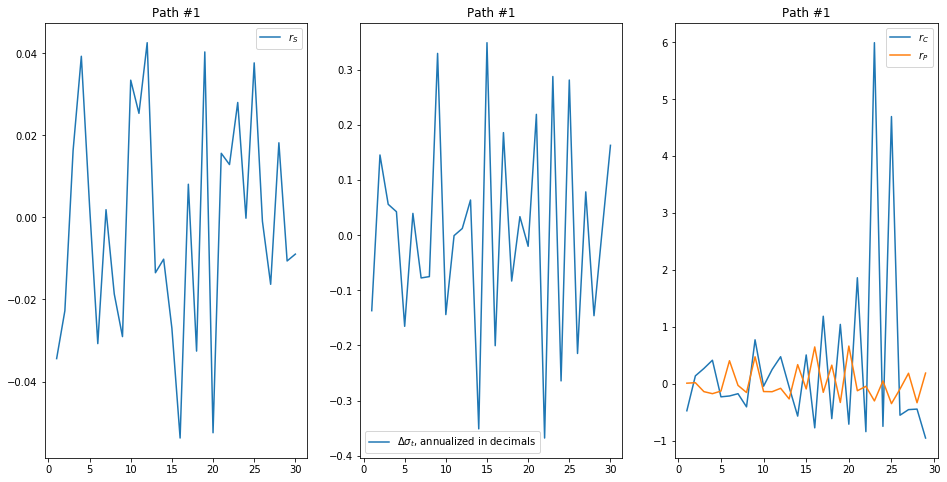

In [21]:
#path 1: Returns
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].plot(range(1,int(T/dt+1)), (S_Path1[1:]/S_Path1[:-1]-1), label = '$r_S$')   
ax[0].legend()
ax[0].set_title("Path #1")
ax[1].plot(range(1,int(T/dt+1)), sigma_path1[1:] - sigma_path1[:-1], label = '$\Delta \sigma_t$, annualized in decimals')   
ax[1].legend()
ax[1].set_title("Path #1")
ax[2].plot(range(1, int(T/dt+1)), r_C_SV_path1 , label = '$r_C$')  
ax[2].plot(range(1, int(T/dt+1)), r_P_SV_path1 , label = '$r_P $')
ax[2].legend()
ax[2].set_title("Path #1")

## 5.d:  Path #2 of Prices and Returns for a fixed $K$ and $T$

In [22]:
#Path 2
S_t = S_Path2
Tmt = (int(T/dt) -  np.linspace(0,  T/dt,  int(T/dt +1) )  ) * dt

## price path of the same call (put) option until maturity
C_SV_path2, sigma_path2 = simulate_OptionPrice_SV_Didactical(S_t, K, Tmt, r, sigma, type='C')
P_SV_path2, sigma_path2 = simulate_OptionPrice_SV_Didactical(S_t, K, Tmt, r, sigma, type='P')

##resulting daily return
r_C_SV_path2 = (C_SV_path2[1:,0] / C_SV_path2[:-1,0])-1
r_P_SV_path2 = (P_SV_path2[1:,0] / P_SV_path2[:-1,0])-1

/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


**Visualization of Prices**

Text(0.5, 1.0, 'Path #2')

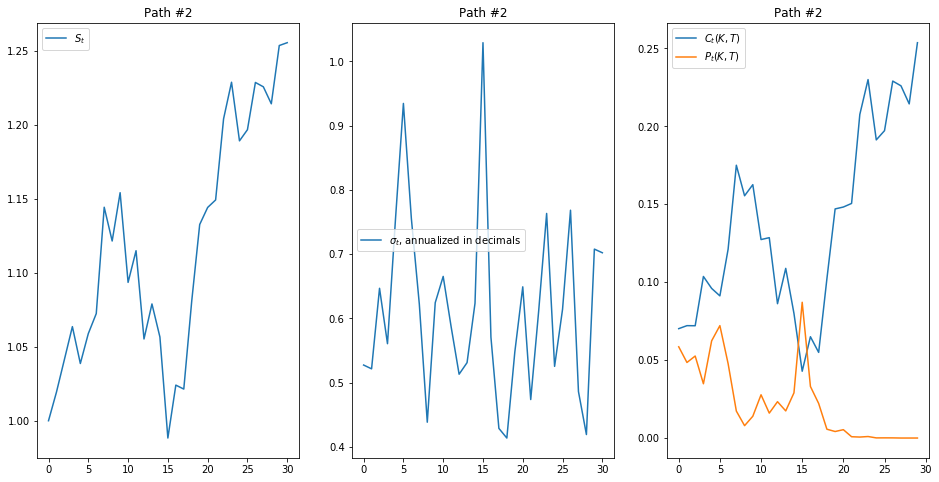

In [23]:
#path 2: Prices
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].plot(range(0,int(T/dt+1)), S_Path2, label = '$S_t$')   
ax[0].legend()
ax[0].set_title("Path #2")
ax[1].plot(range(0,int(T/dt+1)), sigma_path2, label = '$\sigma_t$, annualized in decimals')   
ax[1].legend()
ax[1].set_title("Path #2")
ax[2].plot(range(0, int(T/dt+1)), C_SV_path2 , label = '$C_t(K,T)$')  
ax[2].plot(range(0, int(T/dt+1)), P_SV_path2 , label = '$P_t(K,T)$')
ax[2].legend()
ax[2].set_title("Path #2")

**Visualization of Returns**

Text(0.5, 1.0, 'Path #2')

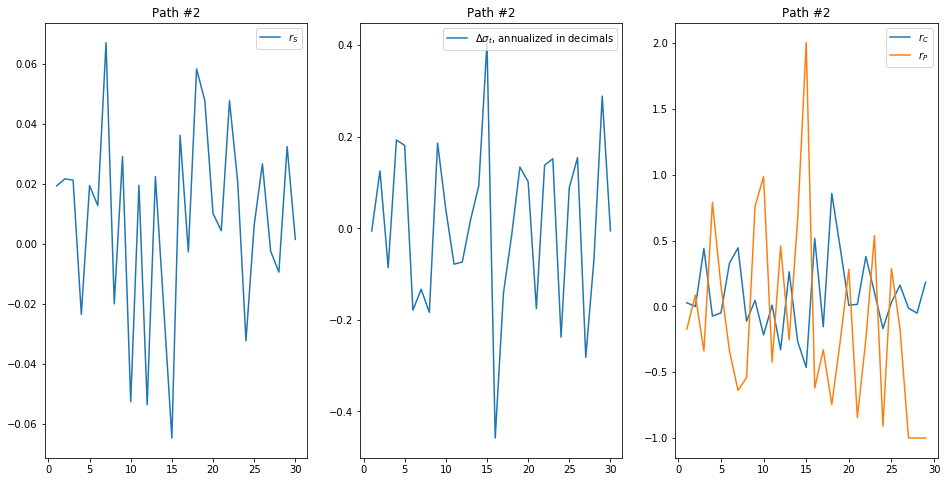

In [24]:
#path 2: Returns
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax[0].plot(range(1,int(T/dt+1)), (S_Path2[1:]/S_Path2[:-1]-1), label = '$r_S$')   
ax[0].legend()
ax[0].set_title("Path #2")
ax[1].plot(range(1,int(T/dt+1)), sigma_path2[1:] - sigma_path2[:-1], label = '$\Delta \sigma_t$, annualized in decimals')   
ax[1].legend()
ax[1].set_title("Path #2")
ax[2].plot(range(1, int(T/dt+1)), r_C_SV_path2 , label = '$r_C$')  
ax[2].plot(range(1, int(T/dt+1)), r_P_SV_path2 , label = '$r_P $' )
ax[2].legend()
ax[2].set_title("Path #2")

## 5.e Probability Density Function of Returns

## 5.e.2 Histogram along Path #1

/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/maximulrich/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


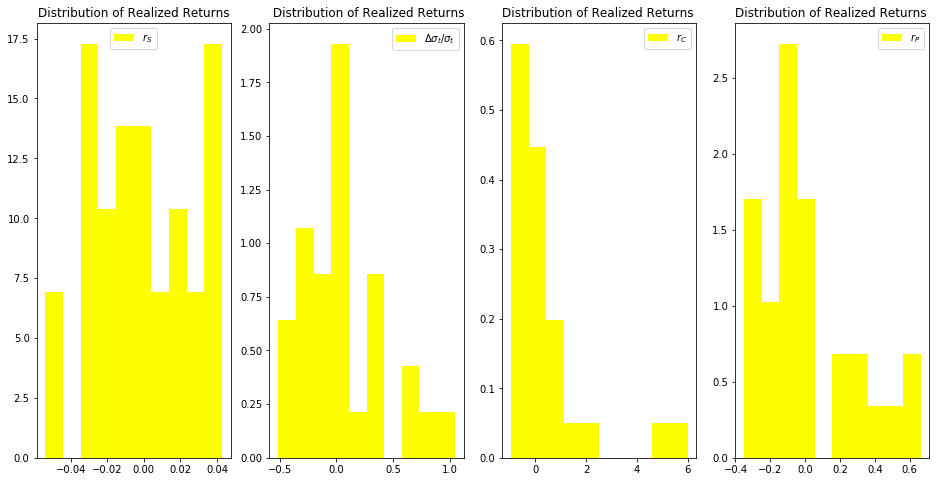

In [25]:
#Realized Time-Series of Daily Option Returns
fig, ax = plt.subplots(1, 4, figsize = (16, 8))
#
ax[0].hist(S_Path1[1:]/S_Path1[:-1]-1, bins = 10, color = 'yellow', density=True, label = '$r_S$')
ax[0].legend()
ax[0].set_title("Distribution of Realized Returns")
#
ax[1].hist(sigma_path1[1:]/sigma_path1[:-1]-1, bins = 10, color = 'yellow',  density=True, label = '$ \Delta \sigma_t / \sigma_t$')
ax[1].legend()
ax[1].set_title(" Distribution of Realized Returns") 
#       
ax[2].hist(r_C_SV_path1, bins = 10, color = 'yellow',   density=True, label = '$r_C$')
ax[2].legend()
ax[2].set_title("Distribution of Realized Returns ")
#
ax[3].hist(r_P_SV_path1, bins = 10, color = 'yellow',  density=True, label = '$r_P$')
ax[3].legend()
ax[3].set_title("Distribution of Realized Returns ")
#
plt.show()

## 5.e.2 Histogram along Path #2

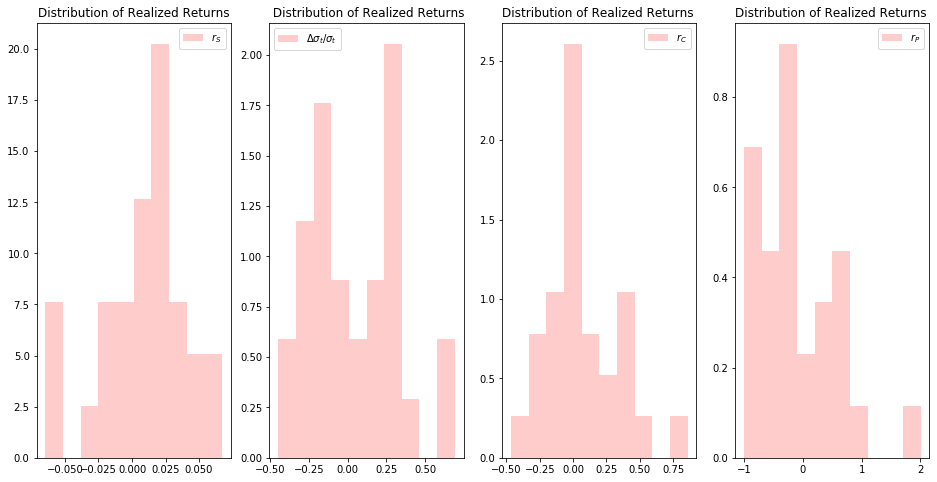

In [26]:
#Realized Time-Series of Daily Option Returns
fig, ax = plt.subplots(1, 4, figsize = (16, 8))
#
ax[0].hist(S_Path2[1:]/S_Path2[:-1]-1, bins = 10, color = 'red', alpha=0.2, density=True, label = '$r_S$')
ax[0].legend()
ax[0].set_title("Distribution of Realized Returns")
#
ax[1].hist(sigma_path2[1:]/sigma_path2[:-1]-1, bins = 10, color = 'red', alpha=0.2, density=True, label = '$ \Delta \sigma_t / \sigma_t$')
ax[1].legend()
ax[1].set_title(" Distribution of Realized Returns") 
#       
ax[2].hist(r_C_SV_path2, bins = 10, color = 'red', alpha=0.2,density=True, label = '$r_C$')
ax[2].legend()
ax[2].set_title("Distribution of Realized Returns ")
#
ax[3].hist(r_P_SV_path2, bins = 10, color = 'red',alpha=0.2, density=True, label = '$r_P$')
ax[3].legend()
ax[3].set_title("Distribution of Realized Returns ")
#
plt.show()

# 6. Which Vol is Priced-in?

**Suppose:** You observe
    

$$
\{C_t\}_{t \in [1,...,T]} \qquad \text{and} \qquad \{P_t\}_{t \in [1,...,T]} 
$$

$$
\\
$$

**So What?:** Can you infer which expected volatility is priced in?

$$
E_t[\sigma_T] \qquad \forall t \in [1,...,T]
$$

$$
\\
$$

**Why?:** Besides the obvious (for pricing purpose), it might be good time $t$ forecast for $\sigma_T$ ; extracted from option markets.

## 6.1 Black-Scholes (Option)-implied (Expected) Volatility

**Punchline:** Different option pricing models imply different prices. Yet, they all imply a **monotonone positive relationship between price of an option and underlying volatility**.

**Industry-Standard:** Black-Scholes option pricing model is used to back out $\sigma_t$ at $t \in [1,...,T]$. To be precise, one should call that quantity
    
$$
\sigma^{BS}_t(O_t, K, T) \qquad \text{for} \qquad O_t \in [C_t, P_t]
$$
    

**Mathematically:**

\begin{equation*}
\sigma^{BS}_t(O_t, K,T) := \arg_{\sigma} \; \left[ O_t(K,T) - O^{BS}(S_t, \sigma, r_t, K, T)  = 0\right]
\end{equation*}

In [27]:
def BS_PricingError(sigma, MarketOptionPrice, S, K, T, r, type='C'):
    #M: note: first variable is the one for which one later optimizes, the others are constants for the function (args)
    
    return black_scholes(S, K, T, r, sigma, type) - MarketOptionPrice  

## 6.2 Application: Find $\sigma^{BS}_t(O_t, K, T)$ for one path of $O_t(K,T)$

**Root Finder:** Newton-Raphson and/or Bisection Method 

### 6.2.1 Bisection Method


In [28]:
def IV_BS_bisection(O_t, S_t, K, Tmt, r, type='C'):
    IV = np.zeros(len(O_t))
    
    #start time recording
    startTime = time.time()
    
    #LB and UB for Bisection
    IV_lb =  1e-5
    IV_ub =  1e5
    for t in range(len(IV)):
        IV[t]         = optimize.bisect(BS_PricingError, IV_lb, IV_ub, args=(O_t[t], S_t[t], K, Tmt[t], r, type))
        
    #end time recording
    endTime = time.time()
    
    return IV, endTime-startTime
    

In [29]:
#call bisection method for time-series of S_t and C_t
IV_Path1_bisec, t_bisec  = IV_BS_bisection(C_SV_path1[:-1], S_Path1[:-1], K, Tmt[:-1], r, 'C')

### 6.2.2 Newton Raphson Method

**Requirement:** 
    
$$
\frac{\partial O^{BS}(\sigma, .)}{\partial \sigma} \qquad \text{must be provided as input to root finder}
$$

**Black-Scholes Model:** That so-called 'vega' quantity is known analytically and coincides for calls and puts

$$
\text{vega}^{BS}(\sigma, S_t, K, T, r) = S_t \times N'(d_1) \times \sqrt{T-t}
$$

In [30]:
def vega(sigma, MarketOptionPrice, S, K, T, r, type='C'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
        
    return vega

Newton-Raphson requires good starting values. Here, we use knowledge that the conditional vol of a stock return is somewhere at 45%

In [31]:
def IV_BS_NewtonR(O_t, S_t, K, Tmt, r, type_='C'):
    
    IV = np.zeros(len(O_t))
    
    #start time recording
    startTime = time.time()
    
    #(hopefully) smart start value
    IV_0 = 0.45
    for t in range(len(IV)):
         #args for newton method
        args_         = (O_t[t], S_t[t], K, Tmt[t], r, type_)
        IV[t]         = optimize.newton(BS_PricingError, IV_0, vega, args_)
        
    #end time recording
    endTime = time.time()
    
    return IV, endTime-startTime

In [32]:
#call NewtonR Method
IV_Path1_NR, t_NR  = IV_BS_NewtonR(C_SV_path1[:-1], S_Path1[:-1], K, Tmt[:-1], r, 'C')

**Let's Visualize Accuracy and Speed**

Text(0.5, 1.0, 'Interpolation Error')

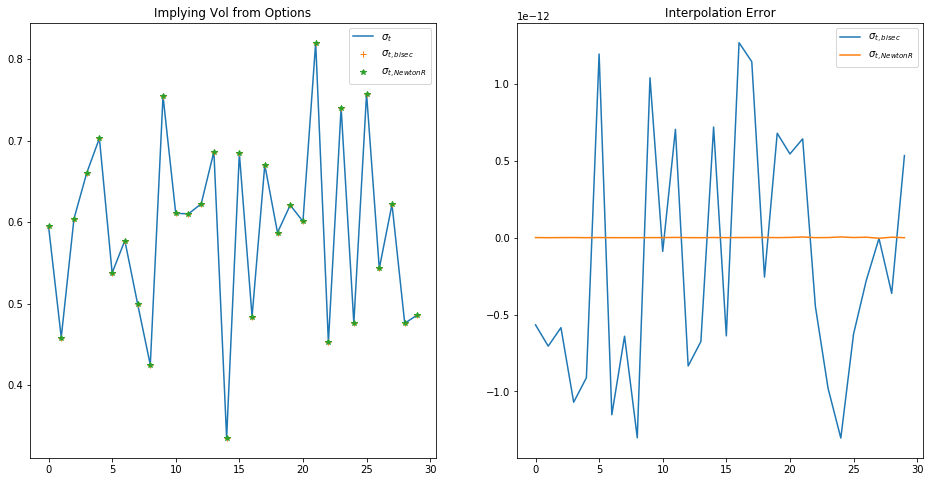

In [33]:
#sigma_t vs interpolations vs fitting error

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(range(0,int(T/dt)), sigma_path1[:-1], label = '$\sigma_t$')   
ax[0].plot(range(0,int(T/dt)), IV_Path1_bisec, '+', label = '$\sigma_{t,bisec}$')
ax[0].plot(range(0,int(T/dt)), IV_Path1_NR, '*', label = '$\sigma_{t,NewtonR}$')
ax[0].legend()
ax[0].set_title("Implying Vol from Options")
#
ax[1].plot(range(0,int(T/dt)), sigma_path1[:-1,0] - IV_Path1_bisec, label = '$\sigma_{t,bisec}$')   
ax[1].plot(range(0,int(T/dt)), sigma_path1[:-1,0] - IV_Path1_NR,   label = '$\sigma_{t,NewtonR}$')
ax[1].legend()
ax[1].set_title("Interpolation Error")

 

**speed:**
 

In [34]:
t_bisec

0.253371000289917

In [35]:
t_NR

0.035431861877441406

# 7. Black-Scholes Options of different Strikes 

**Range of Strikes (ITM, ATM, OTM)**

In [34]:
K_         = np.array([0.9, 0.95, 1.0, 1.05, 1.1]) * S_0

## 7.a: PRICE Curve on a Particular Day

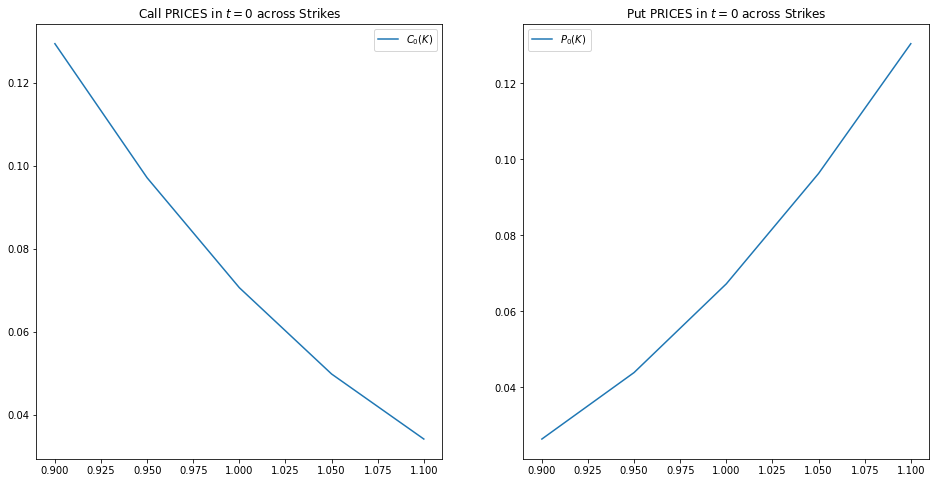

In [35]:
C_ = np.zeros(K_.shape[0])
P_ = np.zeros(K_.shape[0])

for k in range(0,K_.shape[0]):
    C_[k] = black_scholes(S_0, K_[k], T, r, sigma, 'C')
    P_[k] = black_scholes(S_0, K_[k], T, r, sigma, 'P')
    

#Picture    
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(K_, C_,  label = '$C_0(K)$')   
ax[0].legend()
ax[0].set_title('Call PRICES in $t=0$ across Strikes')
#
ax[1].plot(K_, P_, label = '$P_0(K)$')
ax[1].legend()
ax[1].set_title('Put PRICES in $t=0$ across Strikes')
#
plt.show()
 

## 7.b: VOLATILITY Curve on a Particular Day

**Observation:**

- Calls and Puts of different Strikes have different prices.
$$
\\
$$
- Yet, the underlying priced-in Black-Scholes volatility is different or the same? 

**Get IV_BS for Call and Put PRICE Curve**

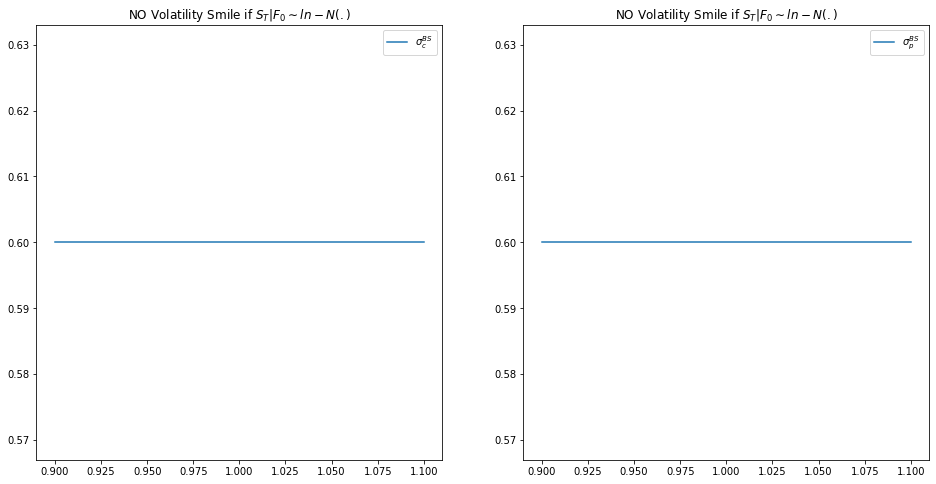

In [36]:
#Newton Raphson
IV_curve_BS_call = C_.copy()
IV_curve_BS_put  = C_.copy()

for k in range (0, K_.shape[0]):
    IV_curve_BS_call[k]  = optimize.bisect(BS_PricingError, 0.01, 10.0, args=(C_[k], S_0, K_[k], T, r, 'C'))
    IV_curve_BS_put[k]   = optimize.bisect(BS_PricingError, 0.01, 10.0, args=(P_[k], S_0, K_[k], T, r, 'P'))
    

#Picture: Volatility Smile in the Black-Scholes Model
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(K_, IV_curve_BS_call,  label = '$\sigma^{BS}_c$')   
ax[0].legend()
ax[0].set_title('NO Volatility Smile if $S_T|F_0 \sim ln-N(.)$')
#
ax[1].plot(K_, IV_curve_BS_put,  label = '$\sigma^{BS}_p$')   
ax[1].legend()
ax[1].set_title('NO Volatility Smile if $S_T|F_0 \sim ln-N(.)$')

plt.show()
 

# 8. Is Option-implied Volatiltiy Curve Constant in Data?

We look at Euro Stoxx 50 call options on December 1st, 2014 with maturity on January 16th 2015 (i.e. thrid Friday of the month), to visualize the Black-Scholes implied call volatilities

In [38]:
call_ES50_Dec1st_2014 = pd.read_csv('euro_stoxx_50_options.txt', sep='\t')
call_ES50_Dec1st_2014.head()

,PRODUCT_ID,CALL_PUT_FLAG,EXP_MONTH,EXP_YEAR,EXERCISE_PRICE,VERSION,YEAR,MONTH,DAY,OPENING_PRICE,HIGHEST_PRICE,LOWEST_PRICE,SETTLEMENT_PRICE,VOLUME,OPEN_INTEREST_ADJUSTED,FACT_DATE
0,OESX,C,1,2015,800,0,2014,12,1,0.0,0.0,0.0,2426.9,0,0,20141201
1,OESX,C,1,2015,1600,0,2014,12,1,0.0,0.0,0.0,1627.2,0,0,20141201
2,OESX,C,1,2015,1650,0,2014,12,1,0.0,0.0,0.0,1577.2,0,0,20141201
3,OESX,C,1,2015,1700,0,2014,12,1,0.0,0.0,0.0,1527.2,0,0,20141201
4,OESX,C,1,2015,1750,0,2014,12,1,0.0,0.0,0.0,1477.3,0,0,20141201


**Parameter of ES 50 Options:**

\begin{equation*}
S_{ES50,0} = 3019,89 \\
T_{ES50}   = 47/365 \qquad \text{ 1.12.2014 - 16.1.2015 (third Friday of the month)} \\
r_{ES50}   = 0.001 \\
C(K)_{ES50} \, \text{are quoted in the text file} \\
K_{ES50} \, \text{are quoted in the text file} \\
\sigma^{BS}(K) \, \text{is unknown and needs to be implied from the data in the text file}
\end{equation*}

In [39]:
# End of day value of Euro Stoxx 50 on 01. Dec 2014
S_ES50_0 = 3019.89

# Maturity of index options. 01.12.2014 - 16.01.2015 (Third Friday of the month)
T_ES50   = 47 / 365

# Risk-free rate
r_ES50 = 0.001

# type of option
type_ES50 = 'C'

# Extract K_ES50 from data file 
K_ES50 = call_ES50_Dec1st_2014["EXERCISE_PRICE"].astype(float)

# Extract C_ES50 from data file
C_ES50 = call_ES50_Dec1st_2014["SETTLEMENT_PRICE"].astype(float)

# Calculate the moneyness for the call options
moneyness_C_ES50 = np.array(S_ES50_0 / K_ES50)

**Extract Black-Scholes-Implied Call Volatility Curve for that particular day**

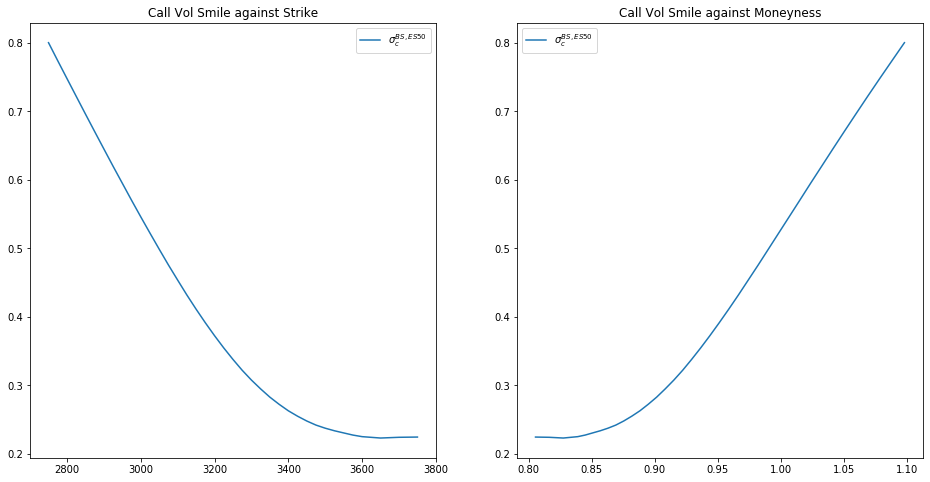

In [40]:
IV_BS_ES50_c_Dec1st_2014 = np.zeros(len(K_ES50))

for k in range(0, len(K_ES50)):
    IV_BS_ES50_c_Dec1st_2014[k] = optimize.bisect(BS_PricingError, 0.01, 10.0, args=(C_ES50[k], S_ES50_0, K_ES50[k], T_ES50, r_ES50, type_ES50))

 
#Picture: Volatility Smile in ES 50 Option Data 
plot_range = np.where(np.logical_and(moneyness_C_ES50 >= 0.8, moneyness_C_ES50 <= 1.1))[0]
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(K_ES50[plot_range], IV_BS_ES50_c_Dec1st_2014[plot_range],  label = '$\sigma^{BS, ES50}_c$')   
ax[0].legend()
ax[0].set_title('Call Vol Smile against Strike')
#
ax[1].plot(moneyness_C_ES50[plot_range], IV_BS_ES50_c_Dec1st_2014[plot_range],  label = '$\sigma^{BS, ES50}_c$')   
ax[1].legend()
ax[1].set_title('Call Vol Smile against Moneyness')

plt.show()